![logo](../../picture/license_header_logo.png)
> **Copyright &copy; 2020 - 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). <br>
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**

# 05 - Time Series Classification Using Machine Learning Techniques
## Notebook Description
This tutorial will walk you through on how to perform time series classification using machine learning techniques. All the techniques are readily available in sktime library. An exercise section is attached for you to practice and hone your skills. Do make good use of it.

By the end of this tutorial, you will be able to:

1. Prepare dataset to be feed into machine learning model
2. Build and apply IndividualBOSS and time series forest model 
3. Perform supervised classification tasks on univariate time series data

## Notebook Outline
Below is the outline for this tutorial:
1. [Notebook Configurations](#configuration)
2. [Dataset](#dataset)
3. [Basic Analytics](#analytics)
4. [Model Development](#model-dev) 

    *  [IndividualBOSS](#boss) 
    *  [Time Series Forest](#tsf)
5. [Evaluation](#evaluation)
6. [Exercise](#exercise)
7. [Reference](#reference)
8. [Bonus](#bonus)



## <a name="configuration">Notebook configurations</a>
Following are the modules that will be used for this tutorial. This notebook will heavily use `sktime` as they provide great API for time series modeling. You can find out more about them [here](https://www.sktime.org/en/latest/about.html).

In [1]:
# Importing libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
from sktime.datasets import load_gunpoint
from sklearn.preprocessing import LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sktime.utils.slope_and_trend import _slope
from sktime.classification.compose import TimeSeriesForestClassifier
from sktime.classification.dictionary_based._boss import IndividualBOSS

# seed configuration
seed = 38
np.random.seed(seed)


## <a name="dataset">Dataset</a>
The dataset to be used is the GunPoint dataset. Quoting the dataset descriptions from http://www.timeseriesclassification.com/description.php?Dataset=GunPoint.

`"This dataset involves one female actor and one male actor making a motion with their hand. The two classes are: Gun-Draw and Point: For Gun-Draw the actors have their hands by their sides. They draw a replicate gun from a hip-mounted holster, point it at a target for approximately one second, then return the gun to the holster, and their hands to their sides. For Point the actors have their gun by their sides. They point with their index fingers to a target for approximately one second, and then return their hands to their sides. For both classes, we tracked the centroid of the actor's right hands in both X- and Y-axes, which appear to be highly correlated. The data in the archive is just the X-axis."`

`sktime` has provided some in-built datasets that shipped along with their module, and GunPoint dataset is one of them.

In [2]:
# load dataset
df_train = load_gunpoint(split="train")
df_test = load_gunpoint(split="test")

## <a name="analytics">Basic Analytics</a>
Let's do some basic analytics and see what nugget can we find out of the training dataset! Let first find out the number of rows and columns of the training dataset.

**Note: Since we are not supposed to know any information about the test dataset, we will not perform any analytics on it.**

In [3]:
# compute the number of rows and columns of train data
df_train_rows = df_train.shape[0]
df_train_columns = df_train.shape[1]

print(f"Shape of dataset is: {df_train.shape}")
print("Rows of train data are: " + str(df_train_rows))
print("Columns of train data are: " + str(df_train_columns))

Shape of dataset is: (50, 2)
Rows of train data are: 50
Columns of train data are: 2


So we have 50 rows of training data with 2 features. Let us inspect closely at each feature to find out more information.

In [4]:
# print out the names of the columns
df_train.columns

Index(['dim_0', 'class_val'], dtype='object')

In [5]:
# inspect first 5 rows of data
df_train.head(5)

,dim_0,class_val
0,0 -0.64789 1 -0.64199 2 -0.63819 3...,2
1,0 -0.64443 1 -0.64540 2 -0.64706 3...,2
2,0 -0.77835 1 -0.77828 2 -0.77715 3...,1
3,0 -0.75006 1 -0.74810 2 -0.74616 3...,1
4,0 -0.59954 1 -0.59742 2 -0.59927 3...,2


In [6]:
# inspecting first column
df_train.dim_0.describe()

count                                                    50
unique                                                   50
top       0     -0.61464
1     -0.61499
2     -0.61479
3...
freq                                                      1
Name: dim_0, dtype: object

In [7]:
# inspecting second column
df_train.class_val.describe()

count     50
unique     2
top        2
freq      26
Name: class_val, dtype: object

When using describe method on each column, it appears to not generate much information for us. This is due to the fact that the first column is not ``int`` or ``float`` data type. As for the second column, it only has two values which is `1` and `2`. So it may very well be the label for each sample. Of course, if we check on the documentation for this dataset, we know that this is in fact the case. So to avoid any confusion, we will separate the feature and the label for subsequent analysis.

In [8]:
# split feature and label
x_train, y_train = df_train.dim_0, df_train.class_val
x_test, y_test = df_test.dim_0, df_test.class_val

# count class distribution
train_labels, train_counts = np.unique(y_train, return_counts=True)
print(f"The labels available for train dataset are: {train_labels}")
print(f"The number of samples for each label are: {train_counts}")

The labels available for train dataset are: ['1' '2']
The number of samples for each label are: [24 26]


We see that there are 24 samples with the label `1` and 26 samples with the label `2`. This is a balanced dataset and we do not have to perform any pre-processing to adjust the class distribution. This is often not the case with real-world data, as it usually has class distribution issues. 

Another thing to note that the current class has a `str` data type. We will convert it to `int` label using sklearn's `LabelBinarizer`.

In [9]:
# convert str dtype to int dtype
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train)
y_test_binarized = lb.transform(y_test)

# reassign train_labels and train_counts
train_labels, train_counts = np.unique(y_train_binarized, return_counts=True)

After binarizing the label, we will visualize the data in the form of time plot. The values in `dim_1` are actually values recorded at subsequent timestamp, so a time plot will be able to give us insights on the values for each class.

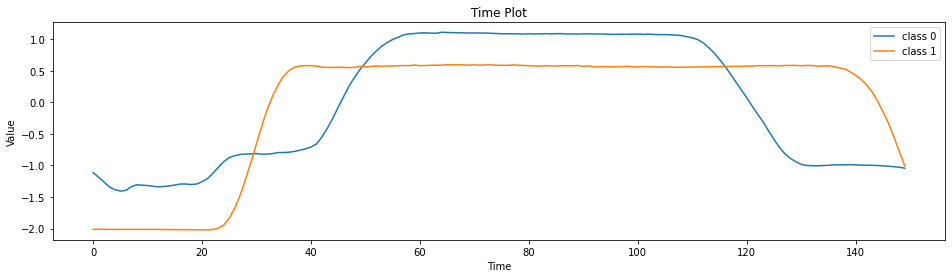

In [10]:
# plot time plot for feature
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in train_labels:
    x_train.loc[y_train_binarized == label].iloc[5].plot(ax=ax, label=f"class {label}")
plt.legend()
ax.set_title("Time Plot")
ax.set_ylabel("Value")
ax.set_xlabel("Time");

The time plot actually shows that the value distribution for class 0 and class 1 are quite different from each other. A reasonably good classification model should be able to classify them fairly accurately. With this information at hand, let us proceed to develop model to perform this task.

## <a name="model-dev">Model Development</a>
After performing some basic analytics on the dataset at hand, we will start to build models to classify time series for this dataset. We will be guiding you through the process of developing two different models here, which are IndividualBOSS and Time Series Forest. Both can be easily implemented using API provided by `sktime`.

In [11]:
x_train_df, x_test_df = x_train.to_frame(), x_test.to_frame()
y_train_array, y_test_array = np.ravel(y_train_binarized), np.ravel(y_test_binarized)

`sktime` model requires the input data to be in either `NumPy ndarray` data type or `Pandas DataFrame` data type. The code above converts the input data to `Pandas DataFrame`.

### a. <a name="boss">IndividualBOSS</a>

BOSS is actually the acronym for Bag-of-SFA Symbols (BOSS). It is an algorithm developed to extract words from time series data. It builds features that represent the frequencies of each word for the time series. It is classified under bag-of-words approach, which is a common approach in time series.

In `sktime`, there are two versions of BOSS being implemented using different API. One of them is `BOSSEnsemble`, whreby it utilizes BOSS algorithm in an ensemble manner. The other one is `IndividualBOSS`, where just one (individual) classifier is built to classify the data. We will be implementing `IndividualBOSS` in the following section.

For more information on BOSS algorithm, please refer to the original paper, "The BOSS is concerned with time series classification in the presence of noise", at [here](https://www.researchgate.net/publication/282271002_The_BOSS_is_concerned_with_time_series_classification_in_the_presence_of_noise).

In [12]:
# building IndividualBOSS model
boss = IndividualBOSS(random_state=seed)
boss.fit(x_train_df, y_train_array)

IndividualBOSS(random_state=38)

As shown above, using `sktime` API allows us to instantiate and fit an IndividualBOSS model in just 2 lines of codes. Pretty neat, huh?

### b. <a name="tsf">Time Series Forest</a>

Time series forest is a tree-based model that is, in a way, akin to random forest for cross-sectional data. At its core, the algorithm consists of many decision trees built on random intervals. It is an ensemble model and classifications are performed through voting method. A time series forest is an ensemble of decision trees built on random intervals.

More detailed information can be found by reading the original paper, "A Time Series Forest for Classification and Feature Extraction" authored by Houtao Deng, George Runger, Eugene Tuv and Martyanov Vladimir at [here](https://arxiv.org/abs/1302.2277).

In [13]:
# building TSF model
tsf = TimeSeriesForestClassifier(n_estimators=100, criterion='entropy', random_state=seed)
tsf.fit(x_train_df, y_train_array)

TimeSeriesForestClassifier(random_state=38)

As shown above, using `sktime` API allows us to instantiate and fit a TSF model in just 2 lines of codes.

C:\Users\User\miniconda3\envs\nbgPy37\lib\site-packages\pandas\plotting\_matplotlib\core.py:584: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000297CB13CCC8> has a label of '_slope' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


<AxesSubplot:>

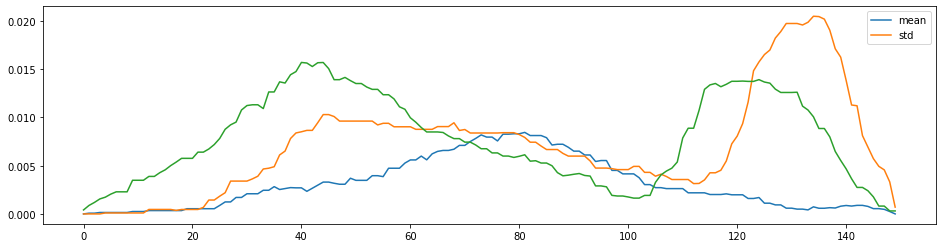

In [14]:
# plot feature importance
feature_importance = tsf.feature_importances_
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
feature_importance.plot(ax=ax)

The feature importance for different features and intervals can also be plotted out as shown above.

## <a name="evaluation">Evaluation</a>
Model evaluation can be done by simply calling the `score` method. This method returns the accuracy score of our model predictions when compared to our ground truth. We will first examine the performance of IndividualBOSS model first.

In [15]:
# compute accuracy score of BOSS model
boss_train_score = boss.score(x_train_df, y_train_array)
boss_test_score = boss.score(x_test_df, y_test_array)

print(f"Accuracy score of IndividualBOSS for training set is: {boss_train_score}")
print(f"Accuracy score of IndividualBOSS for test set is: {boss_test_score}")

Accuracy score of IndividualBOSS for training set is: 1.0
Accuracy score of IndividualBOSS for test set is: 0.9133333333333333


We see that IndividualBOSS model has a good accuracy score when tested on unseen data. Note that this is just by using the default hyperparameteres. We can improve the model performance if we perform hyperparameter tuning.

In [16]:
# compute accuracy score of TSF model
tsf_train_score = tsf.score(x_train_df, y_train_array)
tsf_test_score = tsf.score(x_test_df, y_test_array)

print(f"Accuracy score of TSF for training set is: {tsf_train_score}")
print(f"Accuracy score of TSF for test set is: {tsf_test_score}")

Accuracy score of TSF for training set is: 1.0
Accuracy score of TSF for test set is: 0.96


We can see that TSF model has a pretty stellar performance even before tuning the hyperparameters. It even outperforms IndividualBOSS model by a small margin.

## <a name="exercise">Exercise</a>

This exercise section is attached for you to practice and hone your skills. Try your best effort to complete it without referring to the solution.

### Notebook Configurations
You can import any module that you wish to use for this exercise. However, if you run the cells from the start of this notebook, most probably all the modules that you need has already been imported at this point.

In [17]:
# import modules
### BEGIN SOLUTION


### END SOLUTION

### Dataset
**INSTRUCTIONS:** We will be using ArrowHead, a dataset provided by UCR in their "Time Series Classification Archive". It is also available as part of the `sktime` module, so we can just make use of it to load the data.

In [18]:
# load data using sktime method
### BEGIN SOLUTION


### END SOLUTION

### Basic Analytics
**INSTRUCTIONS**: Perform some basic analytics on the dataset by following the guidelines that are provided in each cell.

In [19]:
# compute the number of rows and columns of train data
### BEGIN SOLUTION
df_train_shape = None
df_train_rows = None
df_train_columns = None
### END SOLUTION

print(f"Shape of dataset is: {df_train_shape}")
print("Rows of train data are: " + str(df_train_rows))
print("Columns of train data are: " + str(df_train_columns))

Shape of dataset is: None
Rows of train data are: None
Columns of train data are: None


In [20]:
# print out the names of the columns
### BEGIN SOLUTION

### END SOLUTION

In [21]:
# inspect first 20 rows of data
### BEGIN SOLUTION

### END SOLUTION

In [22]:
# computing descriptive statistics for first column by indexing using iloc method
### BEGIN SOLUTION

### END SOLUTION

In [23]:
# computing descriptive statistics for second column by indexing using iloc method
### BEGIN SOLUTION

### END SOLUTION

In [24]:
# split feature and label
### BEGIN SOLUTION


### END SOLUTION

In [25]:
# convert str dtype of label into binary matrix
### BEGIN SOLUTION


### END SOLUTION

# count label class distribution
### BEGIN SOLUTION
train_labels, train_counts = None, None
### END SOLUTION

print(f"The labels available for train dataset are: {train_labels}")
print(f"The number of samples for each label are: {train_counts}")

The labels available for train dataset are: None
The number of samples for each label are: None


In [26]:
# plot time plot for feature by class
### BEGIN SOLUTION





### END SOLUTION

### Model Development
**INSTRUCTIONS**: Choose a machine learning model that you are comfortable with and follow the provided guidelines to buiild it out.

In [27]:
# perform required data preparation before feeding into the model
### BEGIN SOLUTION

### END SOLUTION

`sktime` model requires the input data to be in either `NumPy ndarray` data type or `Pandas DataFrame` data type. The code above converts the input data to `Pandas DataFrame`.

In [28]:
# building model
### BEGIN SOLUTION


### END SOLUTION

In [29]:
# plot feature importance (only applies for tree-based model)
### BEGIN SOLUTION



### END SOLUTION

### Evaluation
**INSTRUCTIONS:** Follow the guidelines given in the cells to evaluate performance of model.

In [30]:
# compute accuracy score of model
### BEGIN SOLUTION
model_train_score = None
model_test_score = None
### END SOOLUTION

print(f"Accuracy score of model for training set is: {model_train_score}")
print(f"Accuracy score of model for test set is: {model_test_score}")

Accuracy score of model for training set is: None
Accuracy score of model for test set is: None


## <a name="reference">Reference</a>
1. [Univariate time series classification with sktime](https://github.com/alan-turing-institute/sktime/blob/master/examples/02_classification_univariate.ipynb)
2. [sktime API Reference](https://www.sktime.org/en/latest/api_reference.html)
3. [Dataset: GunPoint](http://www.timeseriesclassification.com/description.php?Dataset=GunPoint)
4. [Dataset: ArrowHead](https://timeseriesclassification.com/description.php?Dataset=ArrowHead)
5. [A Time Series Forest for Classification and Feature Extraction](https://arxiv.org/abs/1302.2277)
6. [The BOSS is concerned with time series classification in the presence of noise](https://www.researchgate.net/publication/282271002_The_BOSS_is_concerned_with_time_series_classification_in_the_presence_of_noise)

## <a name="bonus">Bonus</a>
`pyts` is another module developed for time series classification tasks using Python. It might contains some other features that currently not implemented by `sktime` yet. If you are interested, you can visit their GitHub repo at [here]((https://github.com/johannfaouzi/pyts) for more information.